# 2. Data Balance with Oversampling
---

In this notebook, we will look at the hashtags labels for each image, and fix the imbalance.

## Import Libraries (the following cells are copied from notebook 1)

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sys
sys.path.append("../src")

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [2]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/1113124810_tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target.head(5)

,filename,labels
0,sea_image_50.jpg,sea instapic instagram trip travel air beach b...
1,sea_image_1284.jpg,sea air beach boat earth fish ice island lake ...
2,sea_image_1122.jpg,sea love air beach boat earth fish ice island ...
3,sea_image_1679.jpg,beach sea trip island japan air beach boat ear...
4,sea_image_1736.jpg,sun sand sea sky friend beach thailand trip ad...


In [3]:
# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
X_df = pd.DataFrame(X.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, X_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = X_df.shape[1]

## Visualize the data imbalance

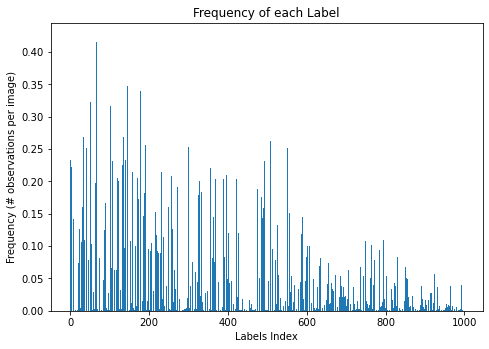

Variance in Frequency: 0.006810539593577393


In [4]:
def display_probability_bar_graph(label_series):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    row_names = np.arange(0,label_series.shape[0])#label_prob_df.index
    ax.bar(row_names,label_series)
    ax.set_title('Frequency of each Label')
    ax.set_ylabel('Frequency (# observations per image)')
    ax.set_xlabel('Labels Index')
    plt.show()
    print("Variance in Frequency:",label_series.var())
display_probability_bar_graph(X_df.sum(axis=0) / X_df.shape[0])

## Balance the data
Idea: We need to duplicate rows (images), so that all labels have the same frequency. If possible, we'd like to minimize the number of images duplicated. (Maybe also make small changes (crop or rotate) on the duplications)

#### Implementation 1: 
Solve the equation X(v)=0 ! (Find the kernel of X)

In [5]:
a = X_df.to_numpy()
row_multiples = null_space(a)

MemoryError: Unable to allocate 24.5 GiB for an array with shape (57383, 57383) and data type float64

Note the memory allocation issue! We will have to try something else.

#### Implementation 2:
We greedily choose a row with the least-represented labels to duplicate. Every iteration we duplicate the least-represented k rows.

In [6]:
#metrics for row duplication (more iterations and lower k yields better performance but slower)
num_iterations = 1000
k = 50 #number of images to duplicate per iteration

In [7]:
#dataframe appended to X_df in order to balance it
duplication_list_df = pd.DataFrame()

#frequency of each label in dataset
label_freq_df = X_df.sum(axis=0)

#find images to duplicate in each iteration
for i in range(num_iterations):
    
    #find probability of each label
    label_prob_df = label_freq_df / (X_df.shape[0] + i*k)
    label_prob_df_mean = label_prob_df.mean() 
    
    #evaluate score of each instance (score is an arbitary metric: number of labels that are underrepresented)
    labels_above_mean_mask = 1 * (label_prob_df < label_prob_df_mean)
    instance_scores = X_df.dot(labels_above_mean_mask) + (0 == X_df).dot(labels_above_mean_mask == 0)
    
    #find images to duplicate
    duplicated_rows_indices = np.argpartition(-1 * instance_scores, k)[:k]
    
    #mask the rows to duplicate (only keep tags less frequent than mean)
    duplicated_rows = X_df.iloc[duplicated_rows_indices] * labels_above_mean_mask
    
    #update the label frequency using k least likely instances
    label_freq_df += duplicated_rows.sum(axis=0)
    
    #update the duplication dict   
    duplication_list_df = duplication_list_df.append(duplicated_rows)
    
    #check variance and print
    new_var = label_prob_df.var()
    print("Completed",i+1,"iterations of",k,"duplications. Previous Variance:",label_prob_df.var())
        
print('Done!')
    

revious Variance: 0.002177483867959967
Completed 768 iterations of 50 duplications. Previous Variance: 0.0021750125940978825
Completed 769 iterations of 50 duplications. Previous Variance: 0.0021724980588275857
Completed 770 iterations of 50 duplications. Previous Variance: 0.0021700574071376443
Completed 771 iterations of 50 duplications. Previous Variance: 0.002167599455287248
Completed 772 iterations of 50 duplications. Previous Variance: 0.002165096998618247
Completed 773 iterations of 50 duplications. Previous Variance: 0.002162639110376853
Completed 774 iterations of 50 duplications. Previous Variance: 0.0021602125573123615
Completed 775 iterations of 50 duplications. Previous Variance: 0.002157719194896326
Completed 776 iterations of 50 duplications. Previous Variance: 0.002155292233702894
Completed 777 iterations of 50 duplications. Previous Variance: 0.002152881140197393
Completed 778 iterations of 50 duplications. Previous Variance: 0.0021504004863117125
Completed 779 iterati

In [8]:
#duplicate the lines specified in duplication_list
balanced_X_df = X_df.append(duplication_list_df)

## Visualized Balanced Data

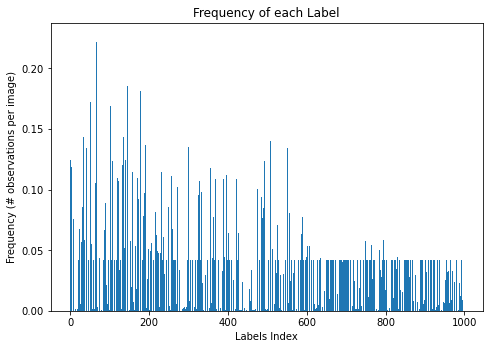

Variance in Frequency: 0.0016923952429660268


In [9]:
display_probability_bar_graph(balanced_X_df.sum(axis=0) / balanced_X_df.shape[0])

## Save the dataframes as a files

In [10]:
import os
tag_list_pathname = os.path.join("..","HARRISON","tag_list_oversampled.txt")
data_list_pathname = os.path.join("..","HARRISON","data_list_oversampled.txt")

tag_list_oversampled_df = balanced_X_df.dot((balanced_X_df.columns.to_numpy() + " "))
data_list_oversampled_df = target.loc[balanced_X_df.index,'filename']

tag_list_oversampled_df.to_csv(tag_list_pathname,header=False,index=False)
data_list_oversampled_df.to_csv(data_list_pathname,header=False,index=False)